In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchcde
import h5py
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
targetdir = '/work/hmzhao/KMT_data/'
with h5py.File(targetdir + 'processed_data.h5', mode='r') as dataset_file:
    X_even = torch.tensor(dataset_file['X'][...]).float()
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even)

In [3]:
q = torch.tensor([
    # Planet/Binary
    0.43, 0.10, 0.23, 0.045, 0.23,
    # Binary/Plan
    0.55, 0.18, 0.036, 0.048, 0.1,
    0.14, 0.17, 0.14, 0.13, 0.034,
    0.17, 0.43, 0.2,
    # Binary
    0.23, 0.356, 0.07, 0.50, 0.23, 
    0.17, 0.046, 0.4, 0.32, 0.19, 
    0.59, 0.86, 0.25, 0.37, 0.23,
    0.95, 0.58, 0.53, 0.046, 0.46,
    0.095, 0.90, 0.37, 0.36, 0.72,
    0.50, 0.11, 0.78, 0.42, 0.50,
    0.88, 0.73, 0.74, 0.15, 0.58,
    0.15, 0.43, 0.96, 0.086, 0.76,
    0.28, 0.67, 0.69, 0.23, 0.56,
    0.50, 0.08, 0.74, 0.67, 0.20
])

In [4]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_00.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = 6
input_dim = X_even.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [5]:
def get_negloglik(pi, normal, y):
    normal = torch.distributions.Normal(normal.loc[:, :, [2]], normal.scale[:, :, [2]])
    loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
    loglik = torch.sum(loglik, dim=2)
    loss = -torch.logsumexp(torch.log(pi.probs) + loglik, dim=1)
    return loss


num = len(X_even)
batchsize = len(X_even)
pred = torch.zeros((num, 6))
nll = torch.zeros((num,))
model.eval()
for i in tqdm(range(num // batchsize)):
    batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    pi, normal = model(batch)
    pred[i*batchsize:i*batchsize+batchsize] = model.sample(pi, normal).detach().cpu()
    nll[i*batchsize:i*batchsize+batchsize] = get_negloglik(pi, normal, torch.log10(q).reshape(-1, 1)[i*batchsize:i*batchsize+batchsize].float().to(device)).detach().cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

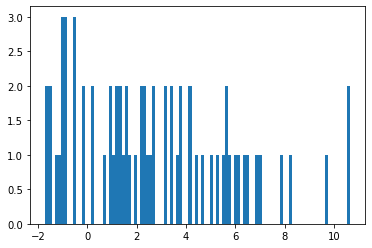

In [6]:
plt.hist(nll.numpy(), bins=100)
plt.show()

In [7]:
10**pred[:, 2]


tensor([0.0556, 0.6053, 0.8476, 0.0591, 0.2549, 0.3827, 0.1312, 0.2648, 0.0052,
        0.6345, 0.1726, 0.0308, 0.4784, 0.2378, 0.1808, 0.0371, 0.3815, 0.0536,
        0.3827, 0.5003, 0.0597, 0.4806, 0.2618, 0.0499, 0.7336, 0.5703, 0.7136,
        0.1540, 0.0435, 0.3154, 0.0914, 0.0145, 0.0899, 0.0836, 0.5765, 0.1221,
        0.0807, 0.2243, 0.0899, 0.2019, 0.2937, 0.3622, 0.0509, 0.0571, 0.2274,
        0.2594, 0.1483, 0.1252, 0.1045, 0.1007, 0.3291, 0.0921, 0.0281, 0.3211,
        0.6137, 0.0506, 0.2723, 0.3194, 0.1066, 0.4111, 0.2246, 0.4146, 0.6929,
        0.0593, 0.5925, 0.4576, 0.1368, 0.3133])

In [13]:
q

tensor([0.4300, 0.1000, 0.2300, 0.0450, 0.2300, 0.5500, 0.1800, 0.0360, 0.0480,
        0.1000, 0.1400, 0.1700, 0.1400, 0.1300, 0.0340, 0.1700, 0.4300, 0.2000,
        0.2300, 0.3560, 0.0700, 0.5000, 0.2300, 0.1700, 0.0460, 0.4000, 0.3200,
        0.1900, 0.5900, 0.8600, 0.2500, 0.3700, 0.2300, 0.9500, 0.5800, 0.5300,
        0.0460, 0.4600, 0.0950, 0.9000, 0.3700, 0.3600, 0.7200, 0.5000, 0.1100,
        0.7800, 0.4200, 0.5000, 0.8800, 0.7300, 0.7400, 0.1500, 0.5800, 0.1500,
        0.4300, 0.9600, 0.0860, 0.7600, 0.2800, 0.6700, 0.6900, 0.2300, 0.5600,
        0.5000, 0.0800, 0.7400, 0.6700, 0.2000])

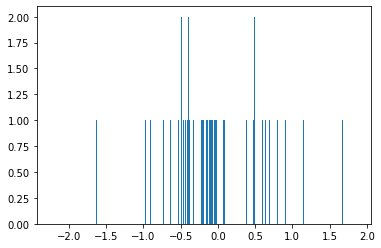

In [28]:
plt.hist(np.log10(np.abs(((pred[:, 2] - torch.log10(q))/torch.log10(q)).numpy())), bins=500)
plt.show()

In [29]:
torch.mean((pred[:, 2] - torch.log10(q))**2)

tensor(0.3772)

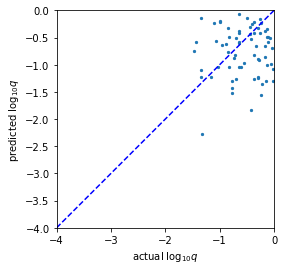

tensor([-0.3665, -1.0000, -0.6383, -1.3468, -0.6383, -0.2596, -0.7447, -1.4437,
        -1.3188, -1.0000])
[-1.2546008  -0.21806407 -0.07180619 -1.2284236  -0.59365416 -0.41717234
 -0.88214356 -0.5770843  -2.2818785  -0.19755843]
mse of log10q:  0.37717318534851074


In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(torch.log10(q), pred.numpy()[:, 2], s=5)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.show()
print(torch.log10(q)[:10])
print(pred.numpy()[:10, 2])
print('mse of log10q: ', torch.mean((torch.log10(q) -  pred.numpy()[:, 2])**2, dim=0).detach().cpu().item())